# Apartment Rental Offers in Germany

#### Columns Descriptions :

- stategdp = state gdp per capita range (0-2)
- heatingType = type of heating
- firingTypes = type of firing
- balcony = does the object have a balcony (T/F)
- telekomUploadSpeed = how fast is the internet upload speed (mbps)
- totalRent = total rent (sum of base rent, service charge and heating cost) -- warm
- parkSpace = has parking space (T/F)
- hasKitchen = has a kitchen (T/F)
- cellar = has a cellar (T/F)
- yearConstructedRange = binned construction year, per decades (1-9)
- livingSpace = living space (sqm)
- goodCondition = condition of the flat (T/F)
- niceInterior = nice interior quality (T/F)
- petsAllowed = are pets allowed (T/F)
- lift = is elevator available (T/F)
- typeOfFlat = type of flat
- buildingType = low_rise, mid_rise, high_rise or unknown
- garden = has a garden (T/F)
- year = ad year (2018-2020)
- energyEfficiencyClass = energy efficiency class (based on binned thermalChar, A_PLUS - H)

__Question to answer :__
- What features affect the rent price of a property the most ?
- Can the totalRent price be predicted using only non-price features so that people can estimate the living cost ?

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn import metrics
import xgboost as xgb
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from scipy.stats import mannwhitneyu, kruskal, shapiro, normaltest, anderson
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, Ridge
from statsmodels.stats import diagnostic
from statsmodels.compat import lzip
from scipy.stats import skew, kurtosis
import pickle

In [3]:
def try_normal(data):
    result = {'Anderson' : {i:j for i,j in zip(anderson(data)[2], anderson(data)[1])}, 'Shapiro': shapiro(data)[1], 
     'K^2': normaltest(data)[1]}
    result['Anderson']['stat'] = anderson(data)[0]
    return result

In [4]:
sns.set_style(style = 'whitegrid')

In [5]:
data = pd.read_csv('immo_data.csv')
pd.set_option('display.max_columns', None)

In [70]:
df = pd.read_csv('cleaned_final.csv')
df['telekomUploadSpeed'] = df['telekomUploadSpeed'].astype('str')
df['year'] = df['year'].astype('str')

In [71]:
df

,state,serviceCharge,heatingType,telekomTvOffer,balcony,pricetrend,telekomUploadSpeed,totalRent,firingTypes,hasKitchen,cellar,yearConstructedRange,baseRent,livingSpace,petsAllowed,lift,typeOfFlat,noRooms,garden,heatingCosts,energyEfficiencyClass,year,goodCondition,niceInterior,parkSpace,position,buildingType
0,Sachsen_Anhalt,210.00,central_heating,NONE,True,0.83,0.0,744.00,oil,False,True,1961_1970,534.00,97.00,negotiable,True,apartment,3.0,False,0.00,D,2019,True,False,False,upper_floor,low_rise
1,Bayern,80.00,central_heating,NONE,True,NaN,0.0,530.00,oil,True,True,1961_1970,450.00,43.00,negotiable,True,apartment,1.0,False,0.00,B,2020,True,False,False,top_floor,mid_rise
2,Sachsen_Anhalt,75.00,central_heating,NONE,True,2.54,0.0,568.00,gas,False,False,before_1950,396.00,72.00,negotiable,False,apartment,2.0,False,97.00,G,2019,True,False,False,upper_floor,low_rise
3,Schleswig_Holstein,190.00,self_contained_central_heating,ONE_YEAR_FREE,True,3.79,40.0,1185.00,geothermal,True,True,2011_2020,995.00,91.00,no,True,penthouse,3.0,False,0.00,A,2020,True,True,True,top_floor,low_rise
4,Mecklenburg_Vorpommern,180.00,unknown,ONE_YEAR_FREE,True,1.34,40.0,765.00,gas,False,True,unknown,585.00,79.00,unknown,False,roof_storey,3.0,False,0.00,D,2019,True,False,True,top_floor,low_rise
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226471,Nordrhein_Westfalen,200.00,oil_heating,ONE_YEAR_FREE,False,3.74,10.0,750.00,unknown,False,True,before_1950,550.00,103.00,no,False,apartment,3.0,False,0.00,NO_INFORMATION,2020,True,True,False,upper_floor,low_rise
226472,Thüringen,160.00,central_heating,NONE,False,2.60,0.0,559.00,unknown,False,True,unknown,399.00,77.00,negotiable,False,other,3.0,False,0.00,E,2019,True,False,True,top_floor,low_rise
226473,Sachsen,90.00,central_heating,NONE,False,0.00,2.4,256.50,gas,True,False,before_1950,166.00,33.00,negotiable,False,roof_storey,1.0,False,0.50,E,2019,True,False,False,top_floor,low_rise
226474,Niedersachsen,200.00,oil_heating,ONE_YEAR_FREE,False,4.69,40.0,650.00,oil,True,True,1971_1980,450.00,85.00,no,False,apartment,3.0,True,0.00,E,2020,True,False,False,top_floor,low_rise


In [72]:
df.columns

Index(['state', 'serviceCharge', 'heatingType', 'telekomTvOffer', 'balcony',
       'pricetrend', 'telekomUploadSpeed', 'totalRent', 'firingTypes',
       'hasKitchen', 'cellar', 'yearConstructedRange', 'baseRent',
       'livingSpace', 'petsAllowed', 'lift', 'typeOfFlat', 'noRooms', 'garden',
       'heatingCosts', 'energyEfficiencyClass', 'year', 'goodCondition',
       'niceInterior', 'parkSpace', 'position', 'buildingType'],
      dtype='object')

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226476 entries, 0 to 226475
Data columns (total 27 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   state                  226476 non-null  object 
 1   serviceCharge          224030 non-null  float64
 2   heatingType            226476 non-null  object 
 3   telekomTvOffer         226476 non-null  object 
 4   balcony                226476 non-null  bool   
 5   pricetrend             224890 non-null  float64
 6   telekomUploadSpeed     226476 non-null  object 
 7   totalRent              226476 non-null  float64
 8   firingTypes            226476 non-null  object 
 9   hasKitchen             226476 non-null  bool   
 10  cellar                 226476 non-null  bool   
 11  yearConstructedRange   226476 non-null  object 
 12  baseRent               226476 non-null  float64
 13  livingSpace            226476 non-null  float64
 14  petsAllowed            226476 non-nu

In [74]:
df.describe()

,serviceCharge,pricetrend,totalRent,baseRent,livingSpace,noRooms,heatingCosts
count,224030.000000,224890.000000,226476.000000,226476.000000,226476.000000,226476.000000,222915.000000
mean,149.631074,3.394368,815.890662,643.962054,72.811339,2.612528,22.220250
std,107.219131,2.001086,567.819341,500.784571,31.520868,0.983341,41.676751
min,0.000000,-12.330000,5.900000,1.000000,0.000000,1.000000,0.000000
25%,95.000000,1.960000,470.000000,335.000000,54.000000,2.000000,0.000000
50%,135.000000,3.390000,650.000000,490.000000,67.000000,3.000000,0.000000
75%,189.390000,4.600000,986.000000,796.000000,86.000000,3.000000,44.000000
max,20392.000000,14.920000,26500.000000,20000.000000,1000.000000,25.000000,3000.000000


In [75]:
df.describe(exclude = 'number').T

,count,unique,top,freq
state,226476,16,Sachsen,51753
heatingType,226476,14,central_heating,108845
telekomTvOffer,226476,3,ONE_YEAR_FREE,192085
balcony,226476,2,True,140155
telekomUploadSpeed,226476,8,40.0,134231
firingTypes,226476,17,gas,106998
hasKitchen,226476,2,False,147244
cellar,226476,2,True,146641
yearConstructedRange,226476,9,unknown,48917
petsAllowed,226476,4,unknown,94599


In [76]:
num_col = df.drop('totalRent', axis = 1).describe().columns
cat_col = df.describe(exclude = 'number').columns

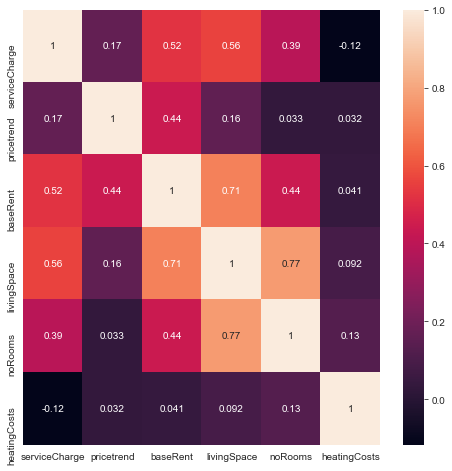

In [77]:
plt.figure(figsize = (8,8))
sns.heatmap(df[num_col].corr(), annot = True)

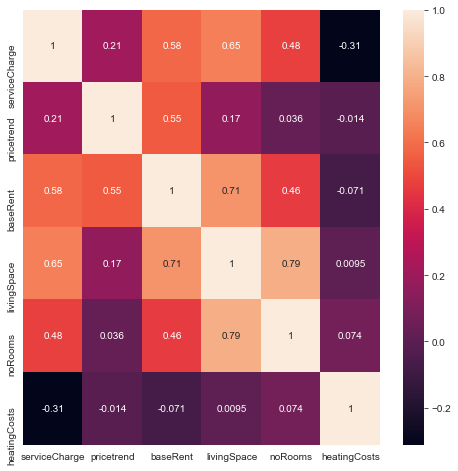

In [78]:
plt.figure(figsize = (8,8))
sns.heatmap(df[num_col].corr('spearman'), annot = True)

In [80]:
num_col = ['livingSpace', 'totalRent', 'noRooms']

In [81]:
def correlation_ratio(categories, measurements):
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0, cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array, n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array, np.power(np.subtract(y_avg_array, y_total_avg), 2)))
    denominator = np.sum(np.power(np.subtract(measurements, y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = np.sqrt(numerator/denominator)
    return eta

In [82]:
cr = []
for i in cat_col:
    for j in num_col:
        print('Correlation Ratio for {} and {}'.format(i, j))
        print('----------------------------------------------')
        corr = correlation_ratio(df[i], df[j])
        if corr > 0.3:
            cr.append([i, j, corr])
        print(corr)
        print('\n')

Correlation Ratio for state and livingSpace
----------------------------------------------
0.20608024643597264


Correlation Ratio for state and totalRent
----------------------------------------------
0.4631040489077317


Correlation Ratio for state and noRooms
----------------------------------------------
0.10444839096103696


Correlation Ratio for heatingType and livingSpace
----------------------------------------------
0.2020652232463511


Correlation Ratio for heatingType and totalRent
----------------------------------------------
0.2678094456747859


Correlation Ratio for heatingType and noRooms
----------------------------------------------
0.11529208532407083


Correlation Ratio for telekomTvOffer and livingSpace
----------------------------------------------
0.05855930938789181


Correlation Ratio for telekomTvOffer and totalRent
----------------------------------------------
0.08723805854677216


Correlation Ratio for telekomTvOffer and noRooms
----------------------------

In [83]:
cr

[['state', 'totalRent', 0.4631040489077317],
 ['yearConstructedRange', 'totalRent', 0.37314473623787825],
 ['lift', 'totalRent', 0.309446306239363],
 ['typeOfFlat', 'livingSpace', 0.30383182155490973],
 ['niceInterior', 'totalRent', 0.37150934022019405]]

In [84]:
def cramers_v(x, y):
    import scipy.stats as ss
    confusion_matrix = pd.crosstab(x, y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1), (rcorr-1)))

In [85]:
corr_cat = []
for i in cat_col:
    temp = []
    for j in cat_col:
        temp.append(cramers_v(df[i], df[j]))
    corr_cat.append(temp)
cat = pd.DataFrame(corr_cat, columns = cat_col, index = cat_col)

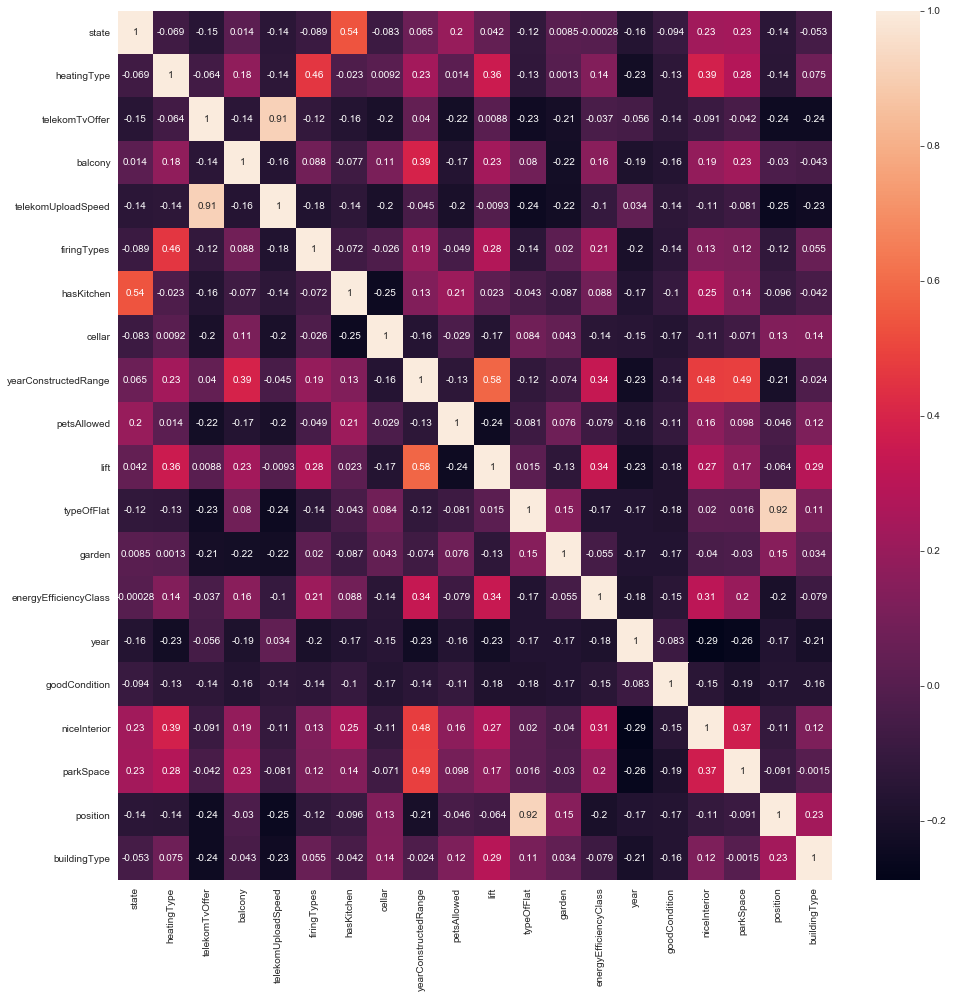

In [86]:
plt.figure(figsize = (16,16))
sns.heatmap(cat.corr(), annot = True)

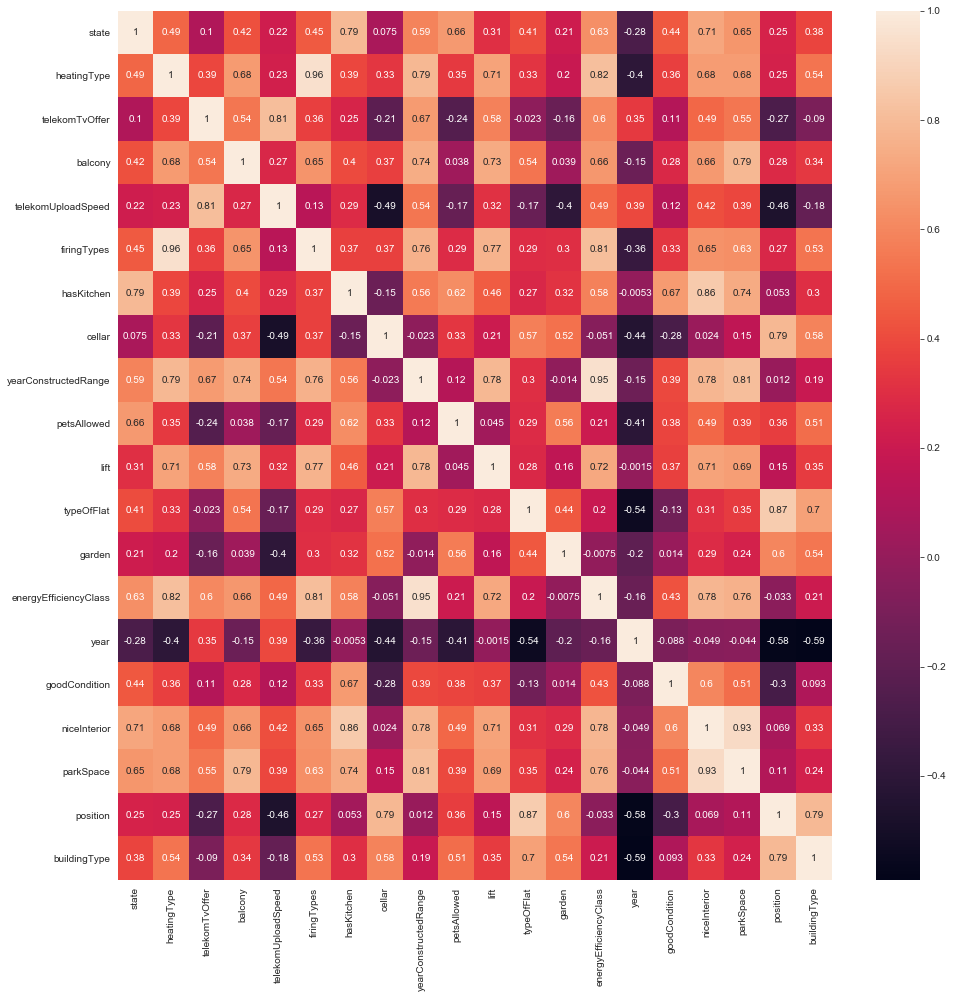

In [87]:
plt.figure(figsize = (16,16))
sns.heatmap(cat.corr('spearman'), annot = True)

# XGB - default

In [50]:
xgbr = xgb.XGBRegressor()


In [51]:
test = df.drop(['serviceCharge', 'heatingCosts', 'baseRent', 'pricetrend'], axis = 1)
cat_col = test.describe(exclude = 'number').columns

In [52]:
df_dummies = pd.get_dummies(test, columns = cat_col, drop_first = True)

In [53]:
X_train, X_test, y_train, y_test = train_test_split(df_dummies.drop('totalRent', axis = 1), df_dummies['totalRent'], test_size = 0.30, random_state = 101)

In [54]:
xgbr.fit(X_train, y_train)

[15:16:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [55]:
predictions = xgbr.predict(X_train)

In [56]:
print('MAE:', metrics.mean_absolute_error(y_train, predictions))
print('MSE:', metrics.mean_squared_error(y_train, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_train, predictions)))
print('R2 Score:', metrics.r2_score(y_train, predictions))

MAE: 155.5435709910743
MSE: 76312.0291436137
RMSE: 276.2463196924327
R2 Score: 0.7665132328373263


In [57]:
predictions = xgbr.predict(X_test)

In [58]:
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))
print('R2 Score:', metrics.r2_score(y_test, predictions))

MAE: 156.06553494442045
MSE: 76336.97943140079
RMSE: 276.29147549535577
R2 Score: 0.7554124297910382


# XGB

In [28]:
xgbr = xgb.XGBRegressor(max_depth = 6, n_estimators = 500, min_samples_split = 2, learning_rate = 0.1, subsample = 0.8)


In [35]:
test = df.drop(['serviceCharge', 'heatingCosts', 'baseRent', 'pricetrend'], axis = 1)
cat_col = test.describe(exclude = 'number').columns

In [36]:
df_dummies = pd.get_dummies(test, columns = cat_col, drop_first = True)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(df_dummies.drop('totalRent', axis = 1), df_dummies['totalRent'], test_size = 0.30, random_state = 101)

In [38]:
xgbr.fit(X_train, y_train)

[15:06:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=6, min_child_weight=1, min_samples_split=2, missing=None,
             n_estimators=500, n_jobs=1, nthread=None, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.8, verbosity=1)

In [39]:
predictions = xgbr.predict(X_train)

In [40]:
print('MAE:', metrics.mean_absolute_error(y_train, predictions))
print('MSE:', metrics.mean_squared_error(y_train, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_train, predictions)))
print('R2 Score:', metrics.r2_score(y_train, predictions))

MAE: 123.47241178590502
MSE: 41665.58574665379
RMSE: 204.12149751227525
R2 Score: 0.8725186182689849


In [41]:
predictions = xgbr.predict(X_test)

In [42]:
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))
print('R2 Score:', metrics.r2_score(y_test, predictions))

MAE: 136.85005395753888
MSE: 62931.70215401154
RMSE: 250.8619185010183
R2 Score: 0.7983636209656964


# Remove Outliers - IQR

In [43]:
no_out = df.copy()

In [44]:
no_out

,state,serviceCharge,heatingType,telekomTvOffer,balcony,pricetrend,telekomUploadSpeed,totalRent,firingTypes,hasKitchen,cellar,yearConstructedRange,baseRent,livingSpace,petsAllowed,lift,typeOfFlat,noRooms,garden,heatingCosts,energyEfficiencyClass,year,goodCondition,niceInterior,parkSpace,position,buildingType
0,Sachsen_Anhalt,210.00,central_heating,NONE,True,0.83,0.0,744.00,oil,False,True,1961_1970,534.00,97.00,negotiable,True,apartment,3.0,False,0.00,D,2019,True,False,False,upper_floor,low_rise
1,Bayern,80.00,central_heating,NONE,True,NaN,0.0,530.00,oil,True,True,1961_1970,450.00,43.00,negotiable,True,apartment,1.0,False,0.00,B,2020,True,False,False,top_floor,mid_rise
2,Sachsen_Anhalt,75.00,central_heating,NONE,True,2.54,0.0,568.00,gas,False,False,before_1950,396.00,72.00,negotiable,False,apartment,2.0,False,97.00,G,2019,True,False,False,upper_floor,low_rise
3,Schleswig_Holstein,190.00,self_contained_central_heating,ONE_YEAR_FREE,True,3.79,40.0,1185.00,geothermal,True,True,2011_2020,995.00,91.00,no,True,penthouse,3.0,False,0.00,A,2020,True,True,True,top_floor,low_rise
4,Mecklenburg_Vorpommern,180.00,unknown,ONE_YEAR_FREE,True,1.34,40.0,765.00,gas,False,True,unknown,585.00,79.00,unknown,False,roof_storey,3.0,False,0.00,D,2019,True,False,True,top_floor,low_rise
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226471,Nordrhein_Westfalen,200.00,oil_heating,ONE_YEAR_FREE,False,3.74,10.0,750.00,unknown,False,True,before_1950,550.00,103.00,no,False,apartment,3.0,False,0.00,NO_INFORMATION,2020,True,True,False,upper_floor,low_rise
226472,Thüringen,160.00,central_heating,NONE,False,2.60,0.0,559.00,unknown,False,True,unknown,399.00,77.00,negotiable,False,other,3.0,False,0.00,E,2019,True,False,True,top_floor,low_rise
226473,Sachsen,90.00,central_heating,NONE,False,0.00,2.4,256.50,gas,True,False,before_1950,166.00,33.00,negotiable,False,roof_storey,1.0,False,0.50,E,2019,True,False,False,top_floor,low_rise
226474,Niedersachsen,200.00,oil_heating,ONE_YEAR_FREE,False,4.69,40.0,650.00,oil,True,True,1971_1980,450.00,85.00,no,False,apartment,3.0,True,0.00,E,2020,True,False,False,top_floor,low_rise


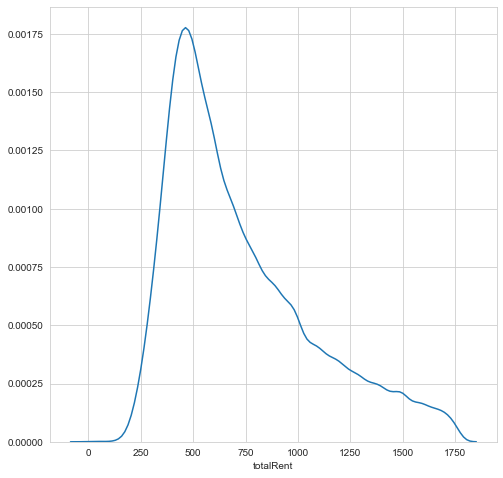

In [45]:
Q1 = no_out['totalRent'].describe()['25%']
Q3 = no_out['totalRent'].describe()['75%']
IQR = Q3 - Q1

plt.figure(figsize = (8,8))
sns.distplot(no_out[(no_out['totalRent'] >= Q1 - (1.5*IQR)) & (no_out['totalRent'] <= Q3 + (1.5 * IQR))]['totalRent'], hist = False)

not_out = no_out[(no_out['totalRent'] >= Q1 - (1.5*IQR)) & (no_out['totalRent'] <= Q3 + (1.5 * IQR))]['totalRent'].index

In [46]:
no_out = no_out.loc[not_out]

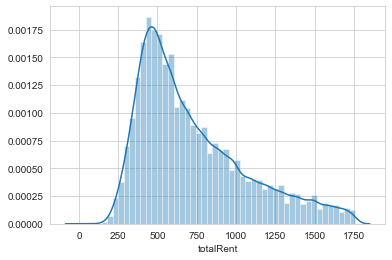

In [47]:
sns.distplot(no_out['totalRent'])

In [48]:
no_out.describe()

,serviceCharge,pricetrend,totalRent,baseRent,livingSpace,noRooms,heatingCosts
count,212116.000000,213104.000000,214458.000000,214458.000000,214458.000000,214458.000000,211092.000000
mean,139.751978,3.282908,723.502663,562.441283,69.224119,2.546314,21.452984
std,67.800631,1.945969,344.243478,305.296690,25.963423,0.928491,37.353674
min,0.000000,-12.330000,5.900000,1.000000,0.000000,1.000000,0.000000
25%,91.500000,1.910000,460.000000,330.000000,53.000000,2.000000,0.000000
50%,130.000000,3.300000,625.000000,465.190000,65.040000,2.500000,0.000000
75%,180.000000,4.480000,913.000000,731.000000,82.120000,3.000000,44.000000
max,1164.190000,14.920000,1760.000000,1755.000000,1000.000000,25.000000,1592.100000


In [49]:
noout = no_out.drop(['serviceCharge', 'pricetrend', 'baseRent', 'heatingCosts'], axis = 1)

# XGB - no out

In [59]:
test = noout.copy()

In [60]:
test = df.drop(['serviceCharge', 'heatingCosts', 'baseRent', 'pricetrend'], axis = 1)
cat_col = test.describe(exclude = 'number').columns

In [61]:
df_dummies = pd.get_dummies(test, columns = cat_col, drop_first = True)

In [62]:
X_train, X_test, y_train, y_test = train_test_split(df_dummies.drop('totalRent', axis = 1), df_dummies['totalRent'], test_size = 0.30, random_state = 101)

In [63]:
xgbr = xgb.XGBRegressor(max_depth = 6, n_estimators = 500, min_samples_split = 2, learning_rate = 0.1, subsample = 0.8)


In [21]:
xgbr.fit(X_train, y_train)

[15:26:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=6, min_child_weight=1, min_samples_split=2, missing=None,
             n_estimators=500, n_jobs=1, nthread=None, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.8, verbosity=1)

In [22]:
predictions = xgbr.predict(X_train)

In [23]:
print('MAE:', metrics.mean_absolute_error(y_train, predictions))
print('MSE:', metrics.mean_squared_error(y_train, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_train, predictions)))
print('R2 Score:', metrics.r2_score(y_train, predictions))

MAE: 97.50599151990512
MSE: 19474.123016916365
RMSE: 139.54971521617793
R2 Score: 0.8358473041004402


In [24]:
predictions = xgbr.predict(X_test)

In [25]:
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))
print('R2 Score:', metrics.r2_score(y_test, predictions))

MAE: 105.39059557501976
MSE: 23018.49720631814
RMSE: 151.71848010812045
R2 Score: 0.8052528686696039


In [82]:
xgbr.feature_importances_

array([0.08212873, 0.00312108, 0.03840647, 0.07654374, 0.00770308,
       0.00381929, 0.04780509, 0.03841264, 0.01273857, 0.01077761,
       0.00756018, 0.00770787, 0.0080289 , 0.05923129, 0.04472889,
       0.00403186, 0.02732695, 0.00204845, 0.00207465, 0.00347146,
       0.00660585, 0.00230777, 0.00161649, 0.00882319, 0.00292445,
       0.00596612, 0.00166774, 0.0035807 , 0.00752742, 0.00133793,
       0.00234368, 0.0020748 , 0.01627663, 0.00232282, 0.00268781,
       0.00144598, 0.00727124, 0.00135706, 0.00210696, 0.00160718,
       0.00229482, 0.00201058, 0.00660245, 0.00400255, 0.00178089,
       0.00458285, 0.00208531, 0.00300996, 0.0010038 , 0.00150861,
       0.00529775, 0.00299129, 0.00166966, 0.00598739, 0.00040376,
       0.00432767, 0.03467935, 0.00331663, 0.00262826, 0.00426082,
       0.00577539, 0.00305499, 0.00329085, 0.12128732, 0.00307637,
       0.00278481, 0.00640071, 0.0040137 , 0.00207662, 0.04323995,
       0.00189582, 0.00282495, 0.00321715, 0.00339127, 0.00416

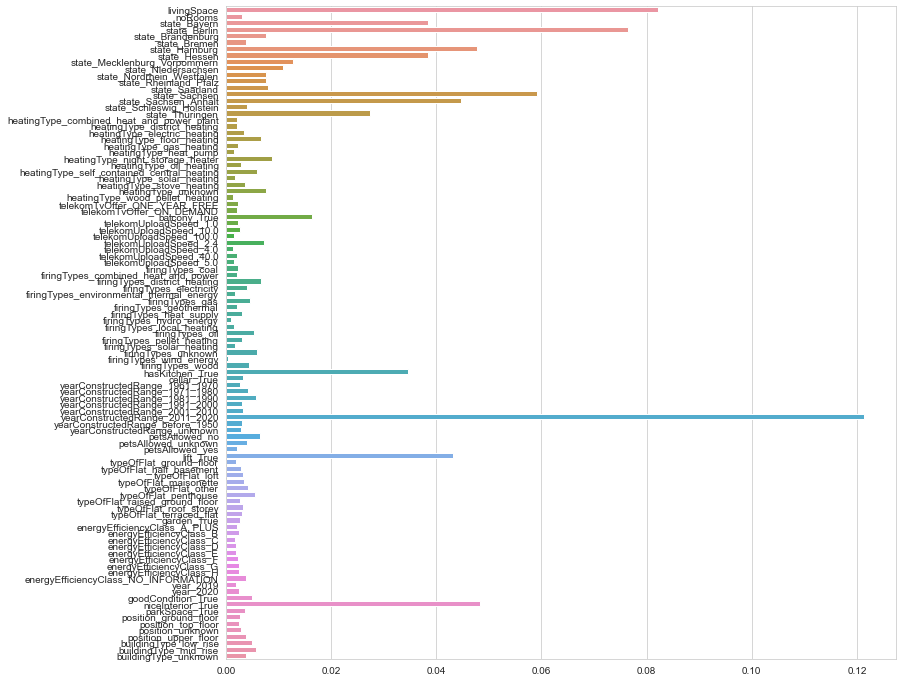

In [83]:
plt.figure(figsize = (12,12))
sns.barplot(x = xgbr.feature_importances_, y = X_train.columns)

In [84]:
import warnings
warnings.filterwarnings('ignore')

from eli5 import show_weights
from eli5.sklearn import PermutationImportance

In [85]:
perm = PermutationImportance(xgbr, scoring = 'r2').fit(X_test, y_test)
show_weights(perm, feature_names = list(X_test.columns))

Weight,Feature
0.7453 ± 0.0025,livingSpace
0.1139 ± 0.0015,state_Sachsen
0.0488 ± 0.0007,state_Sachsen_Anhalt
0.0283 ± 0.0009,yearConstructedRange_2011_2020
0.0235 ± 0.0003,state_Nordrhein_Westfalen
0.0216 ± 0.0008,state_Thüringen
0.0209 ± 0.0007,niceInterior_True
0.0200 ± 0.0007,state_Berlin
0.0196 ± 0.0008,lift_True
0.0186 ± 0.0004,hasKitchen_True


__From the graph and table above we could see that there are more than 1 important features. From feature impoartance we could see that yearConstructed2011_2020 has the highest importance followed by livingSpace and state_Bayern. With permutationImportance, we found that livingSpace has the highest feature importance. This concludes that livingSpace is the most important factor that affects the totalRent of a flat. We also found out that yearConsructed2011_2020 has high feature imoportance because it assumes that the building is fairly new and in good condition.__

[[0.84776523 0.84860814 0.84891167 0.84634406 0.84650888 0.84553037
  0.84553037 0.84553037 0.84553037 0.84553037]
 [0.84165733 0.84251151 0.84178849 0.84060876 0.8410192  0.8422155
  0.84213783 0.84213783 0.84213783 0.84213783]
 [0.83651565 0.83836506 0.83715143 0.83684401 0.8372527  0.83727716
  0.83799133 0.83794713 0.83794713 0.83794713]
 [0.8330922  0.83418487 0.83376709 0.83235917 0.83293693 0.8337884
  0.83427477 0.83384202 0.83442028 0.83442028]
 [0.83124251 0.83172149 0.83089968 0.83018633 0.83088818 0.83074003
  0.83119551 0.83108792 0.83154061 0.83139153]]
[0.84657898 0.84183521 0.83752387 0.8337086  0.83108938]
[ 96506 120632 144759 168885 193012]


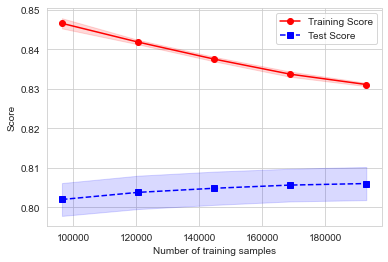

In [39]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(estimator=xgbr,
                                                       X=df_dummies.drop('totalRent', axis =1),
                                                       y=df_dummies['totalRent'],
                                                       train_sizes=np.linspace(0.5, 1.0, 5),
                                                       cv=10)

print(train_scores)
train_mean = np.mean(train_scores, axis=1)
print(train_mean)
print(train_sizes)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='red', marker='o', label='Training Score')
plt.fill_between(train_sizes,
                train_mean + train_std,
                train_mean - train_std,
                alpha=0.15, color='red')

plt.plot(train_sizes, test_mean, color='blue', linestyle='--', marker='s', 
        label='Test Score')
plt.fill_between(train_sizes,
                test_mean + test_std,
                test_mean - test_std,
                alpha=0.15, color='blue')

plt.xlabel('Number of training samples')
plt.ylabel('Score')
plt.legend()
plt.show()

__From the learning curve we can see that there's fair improvement in test score from 100000 train data to 120000 train data. But from 120000 onwards, there's just slight improvement in test score but the train score always drops significantly.__

Cross validation scores: [0.80493101 0.80279103 0.80156023 0.80450403 0.8092538  0.80756481
 0.80670586 0.80088681 0.80363704 0.80288722]


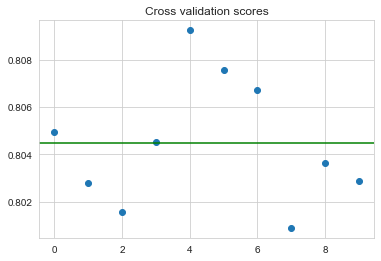

In [87]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator=xgbr,
                        X=X_train,
                        y=y_train,
                        cv=10,
                        n_jobs=1,
                        scoring = 'r2')

print('Cross validation scores: %s' % scores)

plt.title('Cross validation scores')
plt.scatter(np.arange(len(scores)), scores)
plt.axhline(y=np.mean(scores), color='g') # Mean value of cross validation scores
plt.show()

In [88]:
def calc_train_error(X_train, y_train, model):
    predictions = model.predict(X_train)
    MAE = metrics.mean_absolute_error(y_train, predictions)
    MSE = metrics.mean_squared_error(y_train, predictions)
    RMSE = np.sqrt(metrics.mean_squared_error(y_train, predictions))
    R2 = metrics.r2_score(y_train, predictions)
    return{
        'MAE' : MAE,
        'MSE' : MSE,
        'RMSE' : RMSE,
        'R2' : R2,
    }

In [89]:
def calc_validation_error(X_test, y_test, model):
    predictions = model.predict(X_test)
    MAE = metrics.mean_absolute_error(y_test, predictions)
    MSE = metrics.mean_squared_error(y_test, predictions)
    RMSE = np.sqrt(metrics.mean_squared_error(y_test, predictions))
    R2 = metrics.r2_score(y_test, predictions)
    return{
        'MAE' : MAE,
        'MSE' : MSE,
        'RMSE' : RMSE,
        'R2' : R2,
    }

In [90]:
def calc_metrics(X_train, y_train, X_test, y_test, model):
    model.fit(X_train, y_train)
    train_error = calc_train_error(X_train, y_train, model)
    validation_error = calc_validation_error(X_test, y_test, model)
    return train_error, validation_error

In [91]:
from sklearn.model_selection import KFold
K = 5
kf = KFold(n_splits = K, shuffle = True, random_state = 42)

In [93]:
train_errors = []
validation_errors = []
for train_index, val_index in kf.split(df_dummies.drop('totalRent', axis = 1), df_dummies['totalRent']):
    
    # split data
    X_train, X_val = df_dummies.drop('totalRent', axis = 1).iloc[train_index], df_dummies.drop('totalRent', axis = 1).iloc[val_index]
    y_train, y_val = df_dummies['totalRent'].iloc[train_index], df_dummies['totalRent'].iloc[val_index]
    
    # calculate errors
    train_error, val_error = calc_metrics(X_train, y_train, X_val, y_val, xgbr)
    
    # append to appropriate list
    train_errors.append(train_error)
    validation_errors.append(val_error)

In [94]:
matrix = []
for i, j in zip(train_errors, validation_errors):
    matrix.append([i['MAE'], j['MAE'], i['MSE'],
                  j['MSE'], i['RMSE'], j['RMSE'], i['R2'], j['R2']])
calc_matrix = pd.DataFrame(matrix, columns = ['Train MAE', 'Test MAE', 'Train MSE', 'Test MSE', 'Train RMSE', 'Test RMSE',
                                             'Train R2', 'Test R2'])
average = []
for i in calc_matrix.columns:
    average.append(calc_matrix[i].mean())
    
average_mat = pd.DataFrame(average).T
average_mat.columns = ['Train MAE', 'Test MAE', 'Train MSE', 'Test MSE', 'Train RMSE', 'Test RMSE',
                                             'Train R2', 'Test R2']
index_label = []
for i in range(1, len(calc_matrix)+1):
    index_label.append(f'{i} Iteration')
index_label.append('Average')
calculation = pd.concat([calc_matrix, average_mat])
calculation.index = index_label
calculation

,Train MAE,Test MAE,Train MSE,Test MSE,Train RMSE,Test RMSE,Train R2,Test R2
1 Iteration,98.406942,104.714566,19809.441865,22777.282402,140.746019,150.921444,0.832381,0.809856
2 Iteration,98.292462,104.830239,19825.569411,22854.682648,140.803300,151.177653,0.832658,0.807331
3 Iteration,98.163246,105.987845,19731.380360,23310.192127,140.468432,152.676757,0.833504,0.803251
4 Iteration,98.103644,105.328285,19720.318403,23120.054377,140.429051,152.052801,0.833948,0.803194
5 Iteration,97.969699,105.329073,19659.314248,23053.355220,140.211677,151.833314,0.834226,0.804876
Average,98.187199,105.238001,19749.204857,23023.113355,140.531696,151.732394,0.833343,0.805702


In [26]:
residual = y_test - predictions

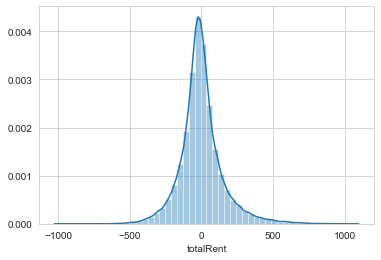

In [27]:
sns.distplot(residual)

In [28]:
try_normal(residual)

/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


{'Anderson': {15.0: 0.576,
  10.0: 0.656,
  5.0: 0.787,
  2.5: 0.918,
  1.0: 1.092,
  'stat': 1038.273171345856},
 'Shapiro': 0.0,
 'K^2': 0.0}

In [30]:
residual.mean()

-0.038489968507593016

In [31]:
skew(residual)

0.8109902623842977

In [32]:
kurtosis(residual)

3.5099061878467497

In [35]:
name = ['F statistic','p-value']
test = sms.het_goldfeldquandt(residual, X_test)
lzip(name, test)

[('F statistic', 1.0010736137604899), ('p-value', 0.4617298713653065)]

In [38]:
diagnostic.acorr_ljungbox(residual, lags = 1)

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/diagnostic.py:524: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


(array([0.00310725]), array([0.95554676]))

In [39]:
filename = 'rentpredict_model_final.sav'
pickle.dump(xgbr, open(filename, 'wb'))

# Scaled - XGB - no out

In [65]:
test = noout.copy()

In [66]:
test.columns

Index(['state', 'heatingType', 'telekomTvOffer', 'balcony',
       'telekomUploadSpeed', 'totalRent', 'firingTypes', 'hasKitchen',
       'cellar', 'yearConstructedRange', 'livingSpace', 'petsAllowed', 'lift',
       'typeOfFlat', 'noRooms', 'garden', 'energyEfficiencyClass', 'year',
       'goodCondition', 'niceInterior', 'parkSpace', 'position',
       'buildingType'],
      dtype='object')

In [67]:
cat_col = test.describe(exclude = 'number').columns

In [68]:
cat_col

Index(['state', 'heatingType', 'telekomTvOffer', 'balcony',
       'telekomUploadSpeed', 'firingTypes', 'hasKitchen', 'cellar',
       'yearConstructedRange', 'petsAllowed', 'lift', 'typeOfFlat', 'garden',
       'energyEfficiencyClass', 'year', 'goodCondition', 'niceInterior',
       'parkSpace', 'position', 'buildingType'],
      dtype='object')

In [69]:
df_dummies = pd.get_dummies(test, columns = cat_col, drop_first = True)

In [70]:
X_train, X_test, y_train, y_test = train_test_split(df_dummies.drop('totalRent', axis = 1), df_dummies['totalRent'], test_size = 0.30, random_state = 101)

In [71]:
scaler = StandardScaler()

In [72]:
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [73]:
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns = X_train.columns)

In [74]:
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

In [75]:
xgbr = xgb.XGBRegressor(max_depth = 6, n_estimators = 500, min_samples_split = 2, learning_rate = 0.1, subsample = 0.8)


In [76]:
xgbr.fit(X_train_scaled, y_train)

[12:47:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=6, min_child_weight=1, min_samples_split=2, missing=None,
             n_estimators=500, n_jobs=1, nthread=None, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.8, verbosity=1)

In [77]:
predictionX = xgbr.predict(X_train_scaled)

print('MAE:', metrics.mean_absolute_error(y_train, predictionX))
print('MSE:', metrics.mean_squared_error(y_train, predictionX))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_train, predictionX)))
print('R2 Score:', metrics.r2_score(y_train, predictionX))

MAE: 97.6310080444788
MSE: 19540.620557026246
RMSE: 139.78776969758923
R2 Score: 0.8352867781927911


In [78]:
predictions = xgbr.predict(X_test_scaled)

print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))
print('R2 Score:', metrics.r2_score(y_test, predictions))

MAE: 105.41185546087135
MSE: 23040.314234965674
RMSE: 151.79036278685703
R2 Score: 0.8050682865179031
